Анализ влияния новостных данных на российский фондовый рынок (NLP / TS)
Схема пайплайна:
Новости
  ↓
Sentiment (ABSA)
  ↓
Агрегация по дню
  ↓
MOEX цены + лаги
  ↓
CatBoost
  ↓
SHAP → интерпретация


In [1]:
import re
import pandas as pd
from collections import defaultdict
import requests
from time import sleep
from pathlib import Path
import time
import json
import os
import numpy as np
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
from catboost import Pool
from sklearn.metrics import mean_squared_error

def clean_name(name):
    """
    Очищает и нормализует название компании для приведения к единому формату.
    
    Функция удаляет юридические суффиксы (ПАО, АО, PJSC), указания на типы акций,
    содержимое в скобках, лишние пробелы и знаки препинания. Также нормализует
    использование кавычек и кавычек-ёлочек.
    
    Args:
        name (str): Исходное название компании (может содержать мусорные суффиксы,
                   лишние пробелы, некорректные кавычки)
    
    Returns:
        str: Очищенное название компании в стандартизированном формате
    
    Examples:
        >>> clean_company_name('ПАО "Газпром" -ао акции обыкн.')
        '"Газпром"'
        
        >>> clean_company_name('МКПАО «Яндекс»')
        '«Яндекс»'
        
        >>> clean_company_name('Сбербанк ПАО')
        'Сбербанк'
        
        >>> clean_company_name('АО "Тинькофф Банк" (ранее Тинькофф Кредитные Системы)')
        '"Тинькофф Банк"'
        
        >>> clean_company_name('Норникель')
        'Норникель'
    
    Notes:
        - Удаляются: ПАО, МКПАО, АО, PJSC, пao, 3ао (опечатки)
        - Удаляются: акции обыкн., акц. пр., преф., -п, -ап, -ао, ап, ао
        - Удаляется всё содержимое в круглых скобках вместе со скобками
        - Нормализуются пробелы (множественные -> одиночные)
        - Удаляются точки и пробелы в конце строки
        - Удаляются внешние кавычки, затем при необходимости добавляются закрывающие
        - Регистронезависимая обработка для всех паттернов
    """
    if not name or not isinstance(name, str):
        return ''
    
    s = str(name).strip()
    patterns = [
        (r'\b(?:ПАО|МКПАО|АО|PJSC|пao|ао|ао\.?|3ао)\b', ''),
        (r'\b(?:акции?\s*обыкн?\.?|акц?\.?\s*пр?\.?|акц?\.?\s*об?\.?|преф?\.?|-п|-ап|-ао|ап|ао)\b', ''),
        (r'-\s*ао\s*$|-\s*$', ''),
    ]
    for pattern, repl in patterns:
        s = re.sub(pattern, repl, s, flags=re.IGNORECASE)
    s = re.sub(r'\([^)]*\)', '', s)
    s = re.sub(r'\s+', ' ', s)
    s = re.sub(r'^\s*(["«“\'])(.+?)(["»”\'])\s*$', r'\2', s)
    s = re.sub(r'[.\s]+$', '', s)
    quote_pairs = [
        ('"', '"'),
        ('«', '»'),
        ('“', '”'),
        ("'", "'"),
    ]
    for open_q, close_q in quote_pairs:
        if open_q in s and close_q not in s and not s.startswith(open_q):
            s += close_q
        elif s.startswith(open_q) and not s.endswith(close_q):
            s += close_q
    return s.strip()

def get_key_companies_from_moex():
    """
    Получает список ключевых компаний (первого уровня листинга) с Московской биржи (MOEX).
    
    Метод отправляет запрос к API MOEX для получения данных по акциям, торгуемым на основном режиме (TQBR),
    и фильтрует компании с первым уровнем листинга (LISTLEVEL = 1).
    
    Returns:
        tuple: Кортеж из двух элементов:
            - dict: Словарь компаний, где ключ - тикер (SECID), значение - словарь с информацией о компании:
                * name (str): Полное наименование компании
                * short_name (str): Краткое наименование компании
                * cleaned_name (str): Очищенное полное наименование (результат clean_name)
                * cleaned_short_name (str): Очищенное краткое наименование (результат clean_name)
                * ticker (str): Тикер компании
            - pandas.DataFrame: DataFrame с исходными данными отфильтрованных компаний
                Колонки: SECID, SECNAME, SHORTNAME, LISTLEVEL, LAST
    
    Example:
        >>> companies_dict, companies_df = get_key_companies_from_moex()
        >>> print(companies_dict['SBER']['cleaned_name'])
        'Сбербанк'
    """
    url = "https://iss.moex.com/iss/engines/stock/markets/shares/boards/TQBR/securities.json"
    
    params = {
        'iss.meta': 'off',
        'securities.columns': 'SECID,SECNAME,SHORTNAME,LISTLEVEL',
        'marketdata.columns': 'LAST'
    }
    
    response = requests.get(url, params=params)
    data = response.json()
    
    df = pd.DataFrame(data['securities']['data'], 
                      columns=data['securities']['columns'])
    
    key_companies = df[df['LISTLEVEL'] == 1].copy()
    
    company_dict = {}
    for _, row in key_companies.iterrows():
        company_dict[row['SECID']] = {
            'name': row['SECNAME'],
            'short_name': row['SHORTNAME'],
            'cleaned_name': clean_name(row['SECNAME']),
            'cleaned_short_name': clean_name(row['SHORTNAME']),
            'ticker': row['SECID']
        }
    
    return company_dict, key_companies

company_dict, df_companies = get_key_companies_from_moex()
print(f"Найдено ключевых компаний: {len(company_dict)}")
print("\nСправочник компаний:")
for ticker, info in list(company_dict.items()):
    print(f"{ticker}: {info['name']} | {info['short_name']}")
    print(f"{info['cleaned_name']} | {info['cleaned_short_name']}")

Найдено ключевых компаний: 69

Справочник компаний:
AFKS: АФК "Система" ПАО ао | Система ао
АФК "Система" | Система
AFLT: Аэрофлот-росс.авиалин(ПАО)ао | Аэрофлот
Аэрофлот-росс.авиалин | Аэрофлот
ALRS: АЛРОСА ПАО ао | АЛРОСА ао
АЛРОСА | АЛРОСА
AQUA: ПАО ИНАРКТИКА | ИНАРКТИКА
ИНАРКТИКА | ИНАРКТИКА
ASTR: Группа Астра ао | iАстра ао
Группа Астра | iАстра
BELU: НоваБев Групп ПАО ао | НоваБев ао
НоваБев Групп | НоваБев
BSPB: ПАО "Банк "Санкт-Петербург" ао | БСП ао
Банк "Санкт-Петербург | БСП
CBOM: "МКБ" ПАО ао | МКБ ао
МКБ | МКБ
CHMF: Северсталь (ПАО)ао | СевСт-ао
Северсталь | СевСт
CNRU: МКПАО "Циан" | Циан
Циан | Циан
DOMRF: ПАО ДОМ.РФ | ДОМ.РФ
ДОМ.РФ | ДОМ.РФ
ELFV: "ЭЛ5-Энерго" ПАО | ЭЛ5Энер ао
ЭЛ5-Энерго | ЭЛ5Энер
ENPG: МКПАО ЭН+ ГРУП ао | ЭН+ГРУП ао
ЭН+ ГРУП | ЭН+ГРУП
EUTR: ЕвроТранс ао | ЕвроТранс
ЕвроТранс | ЕвроТранс
FEES: "ФСК - Россети" ПАО | Россети
ФСК - Россети | Россети
FIXR: ПАО Фикс Прайс | Фикс Прайс
Фикс Прайс | Фикс Прайс
FLOT: Совкомфлот ао | Совкомфлот
Совкомфлот | Совко

In [2]:
def map_news_to_companies(df, company_dict):
    """
    Сопоставляет новостные статьи с компаниями на основе упоминаний в тексте.
    
    Функция анализирует текст каждой новости из DataFrame и ищет в нем названия 
    компаний (полные и сокращенные). При обнаружении совпадения новость 
    добавляется в словарь, сгруппированный по тикерам компаний.
    
    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame с новостными статьями. Должен содержать колонки:
        - 'body': текст новости
        - 'title': заголовок
        - 'date': дата публикации
        - 'time': время публикации
        - 'tags': теги новости
        - 'source': источник
    
    company_dict : dict
        Словарь с информацией о компаниях в формате:
        {
            'TICKER': {
                'cleaned_name': 'Полное название компании',
                'cleaned_short_name': 'Краткое название'
            },
            ...
        }
    
    Returns
    -------
    defaultdict(list)
        Словарь, где ключи - тикеры компаний, значения - списки словарей 
        с данными новостей, в которых упоминается данная компания.
        
    Examples
    --------
    >>> companies = {
    ...     'AAPL': {'cleaned_name': 'Apple Inc.', 'cleaned_short_name': 'Apple'},
    ...     'MSFT': {'cleaned_name': 'Microsoft Corporation', 'cleaned_short_name': 'Microsoft'}
    ... }
    >>> result = map_news_to_companies(news_df, companies)
    >>> result['AAPL'][0]['title']
    'Apple представила новый iPhone'
    
    Notes
    -----
    - Поиск осуществляется без учета регистра (case-insensitive)
    - Используются границы слов (\\b) для точного совпадения
    - Специальные символы в названиях экранируются
    - Одна новость может быть сопоставлена с несколькими компаниями
    """
    news_by_company = defaultdict(list)
    company_patterns = []
    for ticker, info in company_dict.items():
        cleaned_name = re.escape(info['cleaned_name'])
        cleaned_short = re.escape(info['cleaned_short_name'])
        pattern = f"(?:{cleaned_name}|{cleaned_short})"
        company_patterns.append((ticker, pattern))
    for idx, row in df.iterrows():
        body = str(row['body'])
        found_tickers = set()
        for ticker, pattern in company_patterns:
            if ticker not in found_tickers and \
               re.search(r'\b' + pattern + r'\b', body, re.IGNORECASE):
                news_by_company[ticker].append({
                    'title': row['title'],
                    'body': row['body'],
                    'date': row['date'],
                    'time': row['time'],
                    'tags': row['tags'],
                    'source': row['source']
                })
                found_tickers.add(ticker)
    
    return news_by_company
df = pd.read_parquet("RussianFinancialNews/news_collection.parquet")
news_by_company = map_news_to_companies(df, company_dict)
for ticker, news_list in news_by_company.items():
    print(ticker, len(news_list))

GAZP 2696
LSRG 151
PIKK 308
SMLT 583
FLOT 206
LKOH 1411
MTSS 803
ROSN 1287
TATN 318
TRNFP 244
CHMF 398
HEAD 53
MAGN 618
NLMK 637
YDEX 873
NVTK 467
RAGR 443
AFKS 536
RTKM 234
RTKMP 234
SGZH 204
MOEX 9627
PLZL 319
VTBR 1339
AFLT 365
MTLR 244
MTLRP 244
RUAL 240
HYDR 509
MDMG 63
SBER 447
SBERP 447
ASTR 54
ALRS 639
MVID 177
BELU 51
LEAS 64
RENI 628
CNRU 178
AQUA 105
IRAO 212
SVCB 146
OZON 49
EUTR 59
CBOM 61
MBNK 74
VSEH 13
PHOR 441
ELFV 70
FEES 460
UPRO 357
VKCO 86
SELG 120
TGKA 105
POSI 67
SFIN 74
LENT 101
MSNG 91
DOMRF 91
OZPH 21
T 12
X5 9
GEMC 16
BSPB 25
ENPG 7


In [3]:
def split_sentences(text: str):
    """
    Разбивает текст на список предложений.
    
    Функция нормализует пробельные символы, заменяя множественные пробелы/переносы строк
    на одиночные пробелы, затем разделяет текст по знакам препинания (.!?) с последующим
    пробелом. Пустые предложения и предложения короче 5 символов отфильтровываются.
    
    Аргументы:
        text (str): Входной текст для разделения на предложения
        
    Возвращает:
        list: Список предложений в виде строк, очищенных от начальных и конечных пробелов
        
    Пример:
        >>> split_sentences("Привет мир! Как дела? Я в порядке.")
        ['Привет мир!', 'Как дела?', 'Я в порядке.']
    """
    text = re.sub(r"\s+", " ", text)
    return [s.strip() for s in re.split(r"(?<=[.!?])\s+", text) if len(s.strip()) > 5]

def sentence_mentions_company(sentence: str, company_info: dict):
    """
    Проверяет, упоминается ли компания в предложении.
    
    Анализирует предложение на наличие названия компании, её краткого наименования
    или тикера. Поиск выполняется без учёта регистра.
    
    Args:
        sentence (str): Исходное предложение для анализа
        company_info (dict): Словарь с информацией о компании, содержащий ключи:
            - cleaned_name: полное наименование компании
            - cleaned_short_name: краткое наименование компании  
            - ticker: биржевой тикер компании
    
    Returns:
        bool: True, если в предложении найдено упоминание компании 
              (полное название, краткое название или тикер), иначе False
    
    Example:
        >>> company = {
        ...     "cleaned_name": "яндекс",
        ...     "cleaned_short_name": "яндекс",
        ...     "ticker": "YNDX"
        ... }
        >>> sentence_mentions_company("Акции Яндекса выросли", company)
        True
        >>> sentence_mentions_company("Цена на нефть упала", company)  
        False
    """
    s = sentence.lower()
    return (
        company_info["cleaned_name"] in s
        or company_info["cleaned_short_name"] in s
        or company_info["ticker"].lower() in s
    )

def deepseek_local(prompt, model="deepseek-r1:8b", timeout=120):
    """
    Отправляет запрос к локальному экземпляру Ollama для генерации ответа от модели DeepSeek.
    
    Args:
    ----------
    prompt : str
        Текст запроса (промпт), который будет отправлен модели
    model : str, optional
        Название модели в Ollama (по умолчанию "deepseek-r1:8b")
    timeout : int, optional
        Максимальное время ожидания ответа в секундах (по умолчанию 120)
    
    Returns:
    ----------
    str
        Сгенерированный моделью текст ответа
    
    Exceptions:
    ----------
    requests.exceptions.RequestException
        Возникает при проблемах с соединением или таймауте
    requests.exceptions.HTTPError
        Возникает при HTTP-ошибках (статус-код не 200)
    KeyError
        Возникает, если в ответе отсутствует поле "response"
    
    Example:
    -------------------
    >>> response = deepseek_local("Объясни теорию относительности")
    >>> print(response)
    """
    r = requests.post(
        "http://localhost:11434/api/generate",
        json={
            "model": model,
            "prompt": prompt,
            "stream": False
        },
        timeout=timeout
    )
    r.raise_for_status()
    return r.json()["response"]

def deepseek_absa_sentence(sentence, ticker, company_name, model="deepseek-r1:8b"):
    """
    Определяет сентимент (тональность) предложения по отношению к конкретной компании.
    
    Aspect-Based Sentiment Analysis (ABSA) — анализ тональности на уровне аспекта.
    В данном случае аспектом является конкретная компания/тикер.
    
    Args:
        sentence (str): Анализируемое предложение на естественном языке
        ticker (str): Тикер компании (например, "AAPL", "GOOGL")
        company_name (str): Полное название компании
        model (str): Название модели DeepSeek для использования. По умолчанию "deepseek-r1:8b"
    
    Returns:
        dict: Словарь с двумя полями:
            - sentiment (int): -1 (негативный), 0 (нейтральный), 1 (позитивный)
            - confidence (float): Уверенность модели от 0.0 до 1.0
    
    Example:
        >>> deepseek_absa_sentence(
        ...     "Apple выпустила отличные результаты за квартал", 
        ...     "AAPL", 
        ...     "Apple"
        ... )
        {'sentiment': 1, 'confidence': 0.95}
        
        >>> deepseek_absa_sentence(
        ...     "Конкуренты Tesla наращивают производство", 
        ...     "TSLA", 
        ...     "Tesla"
        ... )
        {'sentiment': -1, 'confidence': 0.78}
    
    Note:
        - Анализируется сентимент ТОЛЬКО по отношению к указанной компании
        - Упоминания других компаний или общие высказывания не учитываются
        - При ошибке парсинга возвращается нейтральный сентимент с нулевой уверенностью
        - Модель должна возвращать строго JSON указанного формата
    """
    prompt = f"""
Ты — финансовый аналитик.

Определи сентимент ТОЛЬКО по отношению к компании {company_name} ({ticker})
в следующем предложении.

Верни ТОЛЬКО JSON без текста:

{{
  "sentiment": -1 | 0 | 1,
  "confidence": число от 0 до 1
}}

Предложение:
\"{sentence}\"
"""
    response = deepseek_local(prompt, model=model)
    try:
        json_text = re.search(r"\{.*\}", response, re.S).group()
        result = json.loads(json_text)
        if "sentiment" not in result or "confidence" not in result:
            return {"sentiment": 0, "confidence": 0.0}
        return result
    except Exception:
        return {"sentiment": 0, "confidence": 0.0}

def sentences_to_daily_df(results):
    """
    Преобразует результаты анализа предложений в ежедневный датафрейм с агрегированными 
    показателями тональности для каждого тикера.
    
    Args:
    results : dict
        Словарь с результатами анализа, где ключ - тикер, значение - список предложений
        или словарь с ключом 'sentences', содержащий список предложений.
        Каждое предложение должно содержать поля:
        - date: дата
        - sentiment: значение тональности (float)
        - confidence: уверенность модели (float)
    
    Returns:
    pandas.DataFrame
        Датафрейм с колонками:
        - ticker: тикер
        - date: дата
        - sentiment_score: средневзвешенная тональность за день
        - sentiment_sign: знак тональности (1 - положительная, -1 - отрицательная, 0 - нейтральная)
    
    Notes:
    - Пороги тональности: POS_TH = 0.15, NEG_TH = -0.15
    - Взвешенная сумма рассчитывается как sentiment * confidence
    - Итоговая оценка = взвешенная сумма / сумма confidence
    """    
    POS_TH = 0.15
    NEG_TH = -0.15
    rows = []
    for ticker, data in results.items():
        if isinstance(data, dict) and "sentences" in data:
            sentences = data["sentences"]
        else:
            sentences = data
        for s in sentences:
            rows.append({
                "ticker": ticker,
                "date": pd.to_datetime(s["date"]),
                "sentiment": s["sentiment"],
                "confidence": s["confidence"]
            })
    df = pd.DataFrame(rows)
    if df.empty:
        return df
    daily = (
        df.assign(weighted=df.sentiment * df.confidence)
          .groupby(["ticker", "date"], as_index=False)
          .agg(
              weighted_sum=("weighted", "sum"),
              conf_sum=("confidence", "sum")
          )
    )
    daily["sentiment_score"] = daily["weighted_sum"] / daily["conf_sum"]
    daily = daily.drop(columns=["weighted_sum", "conf_sum"])
    daily["sentiment_sign"] = daily["sentiment_score"].apply(
        lambda x: 1 if x > POS_TH else (-1 if x < NEG_TH else 0)
    )
    return daily

In [4]:
def load_absa_cache(path="absa_results.json"):
    """
    Загружает кэш ABSA-результатов из JSON-файла.
    
    Args:
        path (str): Путь к файлу кэша. По умолчанию "absa_results.json".
    
    Returns:
        dict: Словарь с кэшированными ABSA-результатами. 
              Если файл не найден, возвращает пустой словарь.
    
    Notes:
        Функция проверяет существование файла кэша и загружает из него
        ранее сохраненные результаты аспектно-ориентированного анализа тональности (ABSA).
        При успешной загрузке выводит сообщение в консоль.
    """
    if os.path.exists(path):
        with open(path, "r", encoding="utf-8") as f:
            print(f"ABSA cache loaded: {path}")
            return json.load(f)
    print("ABSA cache not found — starting fresh")
    return {}

def save_absa_cache(results, path="absa_results.json"):
    """
    Сохраняет ABSA-результаты в JSON-файл кэша.
    
    Args:
        results (dict): Словарь с ABSA-результатами для сохранения.
        path (str): Путь к файлу кэша. По умолчанию "absa_results.json".
    
    Returns:
        None
    
    Notes:
        Функция сериализует переданные ABSA-результаты в JSON-формат
        и сохраняет их в файл с отступами в 2 пробела для читаемости.
        После успешного сохранения выводит сообщение в консоль.
    """    
    with open(path, "w", encoding="utf-8") as f:
        json.dump(results, f, ensure_ascii=False, indent=2)
    print(f"ABSA cache saved → {path}")

In [41]:
def run_deepseek_absa(
    news_by_company: dict,
    company_dict: dict,
    model="deepseek-r1:8b",
    cache_path="absa_results.json"
):
    """
    Выполняет аспектно-ориентированный анализ тональности (ABSA) для новостных статей по компаниям.
    
    Метод обрабатывает новости для каждой компании, разбивает текст на предложения,
    фильтрует релевантные предложения (упоминающие компанию) и проводит анализ тональности
    с использованием DeepSeek модели. Результаты кэшируются для повторного использования.
    
    Args:
        news_by_company (dict): Словарь, где ключ - тикер компании, значение - список новостей.
            Каждая новость должна содержать поля:
            - body: текст новости
            - date: дата публикации
            - time: время публикации
            - source: источник новости
            
        company_dict (dict): Словарь с информацией о компаниях, где ключ - тикер.
            Каждая запись должна содержать:
            - name: полное название компании
            - aliases: список альтернативных названий/сокращений (опционально)
            
        model (str): Название модели DeepSeek для анализа тональности.
            По умолчанию: "deepseek-r1:8b"
            
        cache_path (str): Путь к JSON файлу для кэширования результатов.
            По умолчанию: "absa_results.json"
    
    Returns:
        dict: Словарь с результатами анализа по каждому тикеру. Структура:
            {
                ticker: [
                    {
                        "date": str,        # Дата публикации
                        "time": str,        # Время публикации
                        "source": str,      # Источник новости
                        "sentence": str,    # Анализируемое предложение
                        "sentiment": str,   # Тональность (positive/negative/neutral)
                        "confidence": float # Уверенность модели (0-1)
                    },
                    ...
                ],
                ...
            }
    
    Notes:
        - Использует кэширование для избежания повторного анализа одних и тех же предложений
        - Пропускает предложения, не упоминающие компанию (проверка через sentence_mentions_company)
        - Прогресс выполнения отображается в консоли
        - Результаты автоматически сохраняются в кэш после каждого тикера
    
    Example:
        >>> news = {"AAPL": [{"body": "Apple released new iPhone...", 
        ...                   "date": "2024-01-15", 
        ...                   "time": "10:30", 
        ...                   "source": "Reuters"}]}
        >>> companies = {"AAPL": {"name": "Apple Inc.", "aliases": ["Apple"]}}
        >>> results = run_deepseek_absa(news, companies)
        === AAPL | Apple Inc. ===
        [AAPL] news 1/1
        >>> print(results["AAPL"][0]["sentiment"])
        'positive'
    """

    results = load_absa_cache(cache_path)
    for ticker, news_list in news_by_company.items():
        company_info = company_dict[ticker]
        print(f"\n=== {ticker} | {company_info['name']} ===")
        if ticker not in results:
            results[ticker] = []
        existing_keys = {
            (r["date"], r["sentence"]) for r in results[ticker]
        }
        total_news = len(news_list)
        for i, news in enumerate(news_list, 1):
            print(f"[{ticker}] news {i}/{total_news}")
            sentences = split_sentences(news["body"])
            for sent in sentences:
                key = (news["date"], sent)
                if key in existing_keys:
                    continue
                if not sentence_mentions_company(sent, company_info):
                    continue
                absa = deepseek_absa_sentence(
                    sentence=sent,
                    ticker=ticker,
                    company_name=company_info["name"],
                    model=model
                )
                results[ticker].append({
                    "date": news["date"],
                    "time": news["time"],
                    "source": news["source"],
                    "body": news["body"],
                    "sentence": sent,
                    "sentiment": absa["sentiment"],
                    "confidence": round(absa["confidence"], 3)
                })
                existing_keys.add(key)
        save_absa_cache(results, cache_path)
    return results


In [42]:
absa_result = run_deepseek_absa(news_by_company, company_dict)
with open("absa_results.json", "w", encoding="utf-8") as f:
    json.dump(absa_result, f, ensure_ascii=False, indent=2)
agg_results = sentences_to_daily_df(absa_result)

ABSA cache loaded: absa_results.json

=== GAZP | "Газпром" (ПАО) ао ===
[GAZP] news 1/2696
[GAZP] news 2/2696
[GAZP] news 3/2696
[GAZP] news 4/2696
[GAZP] news 5/2696
[GAZP] news 6/2696
[GAZP] news 7/2696
[GAZP] news 8/2696
[GAZP] news 9/2696
[GAZP] news 10/2696
[GAZP] news 11/2696
[GAZP] news 12/2696
[GAZP] news 13/2696
[GAZP] news 14/2696
[GAZP] news 15/2696
[GAZP] news 16/2696
[GAZP] news 17/2696
[GAZP] news 18/2696
[GAZP] news 19/2696
[GAZP] news 20/2696
[GAZP] news 21/2696
[GAZP] news 22/2696
[GAZP] news 23/2696
[GAZP] news 24/2696
[GAZP] news 25/2696
[GAZP] news 26/2696
[GAZP] news 27/2696
[GAZP] news 28/2696
[GAZP] news 29/2696
[GAZP] news 30/2696
[GAZP] news 31/2696
[GAZP] news 32/2696
[GAZP] news 33/2696
[GAZP] news 34/2696
[GAZP] news 35/2696
[GAZP] news 36/2696
[GAZP] news 37/2696
[GAZP] news 38/2696
[GAZP] news 39/2696
[GAZP] news 40/2696
[GAZP] news 41/2696
[GAZP] news 42/2696
[GAZP] news 43/2696
[GAZP] news 44/2696
[GAZP] news 45/2696
[GAZP] news 46/2696
[GAZP] news 47/26

In [43]:
print(agg_results)

     ticker       date  sentiment_score  sentiment_sign
0      AFKS 2022-08-12         0.000000               0
1      AFKS 2022-11-28         0.000000               0
2      AFKS 2022-12-15         0.000000               0
3      AFKS 2023-03-14         0.000000               0
4      AFKS 2023-03-15         0.000000               0
...     ...        ...              ...             ...
1950   YDEX 2024-09-09         1.000000               1
1951   YDEX 2024-09-13         1.000000               1
1952   YDEX 2024-09-23         0.142857               0
1953   YDEX 2024-10-29         0.612903               1
1954   YDEX 2024-11-15         0.000000               0

[1955 rows x 4 columns]


In [44]:
def deduplicate_sentences(df: pd.DataFrame) -> pd.DataFrame:
    """
    Убирает дубликаты одинаковых предложений,
    агрегируя sentiment по confidence
    """
    grouped = (
        df.assign(weighted=df.sentiment * df.confidence)
          .groupby(["ticker", "date", "sentence"], as_index=False)
          .agg(
              weighted_sum=("weighted", "sum"),
              conf_sum=("confidence", "sum"),
              confidence=("confidence", "mean"),
              source=("source", "first"),
              time=("time", "first")
          )
    )
    grouped["sentiment_score"] = grouped["weighted_sum"] / grouped["conf_sum"]
    grouped["sentiment"] = grouped["sentiment_score"].apply(
        lambda x: 1 if x > 0.15 else (-1 if x < -0.15 else 0)
    )
    return grouped.drop(columns=["weighted_sum", "conf_sum"])

In [45]:
def sentences_to_df(results: dict) -> pd.DataFrame:
    """
    Преобразует результаты ABSA в DataFrame по предложениям
    """
    rows = []
    for ticker, data in results.items():
        if isinstance(data, dict) and "sentences" in data:
            sentences = data["sentences"]
        else:
            sentences = data
        for s in sentences:
            rows.append({
                "ticker": ticker,
                "date": pd.to_datetime(s["date"]),
                "time": s.get("time"),
                "source": s.get("source"),
                "sentence": s["sentence"],
                "sentiment": s["sentiment"],
                "confidence": s["confidence"]
            })
    return pd.DataFrame(rows)


In [46]:
def sentences_to_daily_df_from_df(df: pd.DataFrame) -> pd.DataFrame:
    POS_TH = 0.15
    NEG_TH = -0.15

    if df.empty:
        return df

    daily = (
        df.assign(weighted=df.sentiment * df.confidence)
          .groupby(["ticker", "date"], as_index=False)
          .agg(
              weighted_sum=("weighted", "sum"),
              conf_sum=("confidence", "sum"),
              n_sentences=("sentence", "count")
          )
    )
    daily["sentiment_score"] = daily["weighted_sum"] / daily["conf_sum"]
    daily["sentiment_sign"] = daily["sentiment_score"].apply(
        lambda x: 1 if x > POS_TH else (-1 if x < NEG_TH else 0)
    )
    return daily.drop(columns=["weighted_sum", "conf_sum"])

In [47]:
df_sent = sentences_to_df(absa_result)
df_sent = deduplicate_sentences(df_sent)
daily = sentences_to_daily_df_from_df(df_sent)

In [48]:
print(daily)

     ticker       date  n_sentences  sentiment_score  sentiment_sign
0      AFKS 2022-08-12            1         0.000000               0
1      AFKS 2022-11-28            1         0.000000               0
2      AFKS 2022-12-15            1         0.000000               0
3      AFKS 2023-03-14            1         0.000000               0
4      AFKS 2023-03-15            2         0.000000               0
...     ...        ...          ...              ...             ...
1950   YDEX 2024-09-09            1         1.000000               1
1951   YDEX 2024-09-13            1         1.000000               1
1952   YDEX 2024-09-23            1         0.000000               0
1953   YDEX 2024-10-29            2         0.612903               1
1954   YDEX 2024-11-15            1         0.000000               0

[1955 rows x 5 columns]


In [49]:
ticker_news_count = (
    daily.groupby("ticker")["n_sentences"]
         .sum()
         .reset_index(name="total_news")
)
ticker_news_count.sort_values("total_news", ascending=False).head(20)
good_tickers = ticker_news_count.loc[
    ticker_news_count["total_news"] > 200,
    "ticker"
]
daily_filtered = daily[daily["ticker"].isin(good_tickers)].reset_index(drop=True)

In [50]:
print(daily_filtered)

    ticker       date  n_sentences  sentiment_score  sentiment_sign
0     LKOH 2022-06-16            2         0.583333               1
1     LKOH 2022-06-17            1         1.000000               1
2     LKOH 2022-07-13            4         0.890909               1
3     LKOH 2022-07-22            6         0.926380               1
4     LKOH 2022-07-26            5         0.891892               1
..     ...        ...          ...              ...             ...
271   SMLT 2024-11-22            2         0.666667               1
272   SMLT 2024-11-29            3        -1.000000              -1
273   SMLT 2024-12-04            1         1.000000               1
274   SMLT 2024-12-12            1         0.000000               0
275   SMLT 2024-12-13            1        -1.000000              -1

[276 rows x 5 columns]


In [51]:
print("Tickers kept:", daily_filtered["ticker"].nunique())
print("Total daily rows:", len(daily_filtered))

Tickers kept: 2
Total daily rows: 276


In [52]:
news_date_range = (
    daily_filtered
        .groupby("ticker")["date"]
        .agg(
            news_start="min",
            news_end="max",
            n_days="nunique"
        )
        .reset_index()
)

In [53]:
news_date_range.sort_values("news_start")

,ticker,news_start,news_end,n_days
0,LKOH,2022-06-16,2024-12-13,125
1,SMLT,2022-06-17,2024-12-13,151


In [54]:
def load_moex_prices(
    ticker: str,
    start_date: str,
    end_date: str,
    board: str = "TQBR",
    market: str = "shares",
    engine: str = "stock",
    sleep_sec: float = 0.2
):
    url = (
        f"https://iss.moex.com/iss/history/engines/{engine}/"
        f"markets/{market}/boards/{board}/securities/{ticker}.json"
    )

    all_rows = []
    start = 0

    while True:
        params = {
            "from": start_date,
            "till": end_date,
            "start": start,
            "iss.meta": "off",
            "iss.only": "history",
            "history.columns": "TRADEDATE,OPEN,HIGH,LOW,CLOSE,VOLUME"
        }

        r = requests.get(url, params=params)
        data = r.json()["history"]

        if not data["data"]:
            break

        cols = data["columns"]
        rows = data["data"]

        df_part = pd.DataFrame(rows, columns=cols)
        all_rows.append(df_part)

        start += len(rows)
        sleep(sleep_sec)

    if not all_rows:
        return pd.DataFrame()

    df = pd.concat(all_rows, ignore_index=True)
    df["TRADEDATE"] = pd.to_datetime(df["TRADEDATE"])
    df["ticker"] = ticker

    return df


In [55]:
all_prices = []

for _, row in news_date_range.iterrows():
    ticker = row["ticker"]
    start_date = row["news_start"].strftime("%Y-%m-%d")
    end_date = row["news_end"].strftime("%Y-%m-%d")

    print(f"{ticker}: {start_date} → {end_date}")

    df_prices = load_moex_prices(
        ticker=ticker,
        start_date=start_date,
        end_date=end_date
    )

    if not df_prices.empty:
        all_prices.append(df_prices)


LKOH: 2022-06-16 → 2024-12-13
SMLT: 2022-06-17 → 2024-12-13


In [56]:
prices_df = pd.concat(all_prices, ignore_index=True)
prices_df = prices_df.rename(columns={
    "TRADEDATE": "date",
    "OPEN": "open",
    "HIGH": "high",
    "LOW": "low",
    "CLOSE": "close",
    "VOLUME": "volume"
})
prices_df = prices_df.sort_values(["ticker", "date"]).reset_index(drop=True)

In [57]:
prices_df.head()

,date,open,high,low,close,volume,ticker
0,2022-06-16,4116.5,4300.0,4105.0,4261.5,1089748,LKOH
1,2022-06-17,4289.5,4326.0,4137.0,4182.0,499050,LKOH
2,2022-06-20,4202.0,4245.0,4128.0,4209.5,461006,LKOH
3,2022-06-21,4239.0,4279.5,4031.5,4045.0,590551,LKOH
4,2022-06-22,3990.0,4179.5,3932.5,4139.0,745924,LKOH


In [58]:
prices_df.to_parquet("moex_prices.parquet", index=False)

In [59]:
df = prices_df.merge(
    daily_filtered,
    on=["ticker", "date"],
    how="left"
)
df["sentiment_score"] = df["sentiment_score"].fillna(0.0)
df["sentiment_sign"] = df["sentiment_sign"].fillna(0)

In [60]:
df = df.sort_values(["ticker", "date"]).reset_index(drop=True)

In [61]:
SENT_LAGS = [1, 2, 3, 5]
for lag in SENT_LAGS:
    df[f"sentiment_score_lag{lag}"] = (
        df.groupby("ticker")["sentiment_score"].shift(lag)
    )
    df[f"sentiment_sign_lag{lag}"] = (
        df.groupby("ticker")["sentiment_sign"].shift(lag)
    )

In [62]:
PRICE_LAGS = [1, 2, 5]
for lag in PRICE_LAGS:
    df[f"close_lag{lag}"] = df.groupby("ticker")["close"].shift(lag)
    df[f"volume_lag{lag}"] = df.groupby("ticker")["volume"].shift(lag)
df["log_return"] = (
    np.log(df["close"]) - np.log(df.groupby("ticker")["close"].shift(1))
)

In [63]:
ROLLS = [3, 5, 10]

for w in ROLLS:
    df[f"sentiment_roll_mean_{w}"] = (
        df.groupby("ticker")["sentiment_score"]
          .rolling(w)
          .mean()
          .reset_index(level=0, drop=True)
    )

    df[f"return_roll_std_{w}"] = (
        df.groupby("ticker")["log_return"]
          .rolling(w)
          .std()
          .reset_index(level=0, drop=True)
    )


In [64]:
df["target_close_t1"] = df.groupby("ticker")["close"].shift(-1)
df_model = df.dropna().reset_index(drop=True)
FEATURES = [
    "sentiment_score",
    "sentiment_sign",
    "log_return",
    "volume",
    *[f"sentiment_score_lag{l}" for l in SENT_LAGS],
    *[f"sentiment_sign_lag{l}" for l in SENT_LAGS],
    *[f"close_lag{l}" for l in PRICE_LAGS],
    *[f"volume_lag{l}" for l in PRICE_LAGS],
    *[f"sentiment_roll_mean_{w}" for w in ROLLS],
    *[f"return_roll_std_{w}" for w in ROLLS],
]
TARGET = "target_close_t1"

In [65]:
CAT_FEATURES = ["ticker"]
X = df_model[FEATURES + CAT_FEATURES]
y = df_model[TARGET]

In [66]:
split_date = "2024-01-01"
train_idx = df_model["date"] < split_date
test_idx = df_model["date"] >= split_date
X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

In [67]:
model = CatBoostRegressor(
    iterations=1000,
    depth=5,
    learning_rate=0.05,
    loss_function="RMSE",
    eval_metric="RMSE",
    l2_leaf_reg=10,
    cat_features=CAT_FEATURES,
    random_seed=42,
    early_stopping_rounds=50,
    verbose=100
)
model.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    use_best_model=True
)

0:	learn: 1365.3286978	test: 2186.8173727	best: 2186.8173727 (0)	total: 1.69ms	remaining: 1.69s
100:	learn: 165.6712643	test: 788.5549848	best: 788.5549848 (100)	total: 74.4ms	remaining: 662ms
200:	learn: 90.4953279	test: 724.5077352	best: 724.5077352 (200)	total: 135ms	remaining: 538ms
300:	learn: 72.2630938	test: 705.2953811	best: 705.2953811 (300)	total: 197ms	remaining: 457ms
400:	learn: 58.5231613	test: 690.9504381	best: 690.9504381 (400)	total: 256ms	remaining: 383ms
500:	learn: 44.8125739	test: 682.7952804	best: 682.7952804 (500)	total: 317ms	remaining: 315ms
600:	learn: 35.6167050	test: 677.0484671	best: 677.0484671 (600)	total: 380ms	remaining: 252ms
700:	learn: 28.5923691	test: 673.2566257	best: 673.2566257 (700)	total: 442ms	remaining: 189ms
800:	learn: 23.2378847	test: 671.5876118	best: 671.5876118 (800)	total: 501ms	remaining: 124ms
900:	learn: 18.9481400	test: 669.8959287	best: 669.8959287 (900)	total: 562ms	remaining: 61.7ms
999:	learn: 15.4666585	test: 668.7430346	best:

In [68]:
rmse_baseline = np.sqrt(mean_squared_error(y_test, [y_train.mean()] * len(y_test)))
rmse_baseline

2235.1366219186634

In [69]:
model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,close_lag5,33.712943
1,close_lag1,27.642402
2,close_lag2,21.004165
3,ticker,5.340786
4,volume_lag2,1.653661
5,return_roll_std_5,1.195272
6,sentiment_roll_mean_10,1.151135
7,volume_lag5,0.998277
8,return_roll_std_10,0.866843
9,return_roll_std_3,0.866584


In [70]:
model.save_model("catboost_rmse_669.cbm")

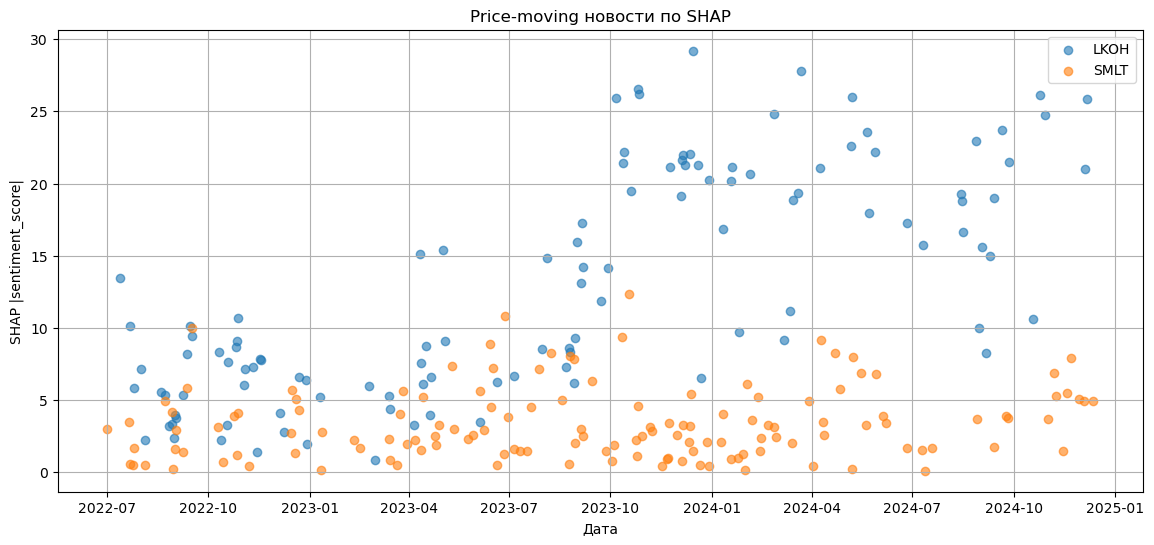

In [71]:
cat_features = ["ticker"]
data_pool = Pool(data=X, label=y, cat_features=cat_features)
shap_values = model.get_feature_importance(
    data=data_pool,
    type="ShapValues"
)
shap_values_only = shap_values[:, :-1]
shap_df = pd.DataFrame(shap_values_only, columns=X.columns)
shap_df["date"] = df_model["date"].values
shap_df["ticker"] = df_model["ticker"].values
shap_df["y_true"] = y.values
shap_df["abs_sentiment_shap"] = np.abs(shap_df["sentiment_score"])
PRICE_SHAP_THRESHOLD = 0.05
price_moving_df = shap_df[shap_df["abs_sentiment_shap"] > PRICE_SHAP_THRESHOLD]
plt.figure(figsize=(14,6))
for ticker in price_moving_df["ticker"].unique():
    df_t = price_moving_df[price_moving_df["ticker"] == ticker]
    plt.scatter(df_t["date"], df_t["abs_sentiment_shap"], label=ticker, alpha=0.6)
plt.xlabel("Дата")
plt.ylabel("SHAP |sentiment_score|")
plt.title("Price-moving новости по SHAP")
plt.legend()
plt.grid(True)
plt.show()

In [72]:
df_model.head()

,date,open,high,low,close,volume,ticker,n_sentences,sentiment_score,sentiment_sign,...,close_lag5,volume_lag5,log_return,sentiment_roll_mean_3,return_roll_std_3,sentiment_roll_mean_5,return_roll_std_5,sentiment_roll_mean_10,return_roll_std_10,target_close_t1
0,2022-07-13,3757.0,3767.0,3619.0,3645.5,585484,LKOH,4.0,0.890909,1.0,...,3962.0,603617.0,-0.028796,0.296970,0.006566,0.178182,0.010960,0.089091,0.015826,3608.0
1,2022-07-22,3552.0,3688.0,3551.0,3688.0,575224,LKOH,6.0,0.926380,1.0,...,3709.0,461637.0,0.041099,0.308793,0.028768,0.185276,0.023981,0.181729,0.022521,3669.0
2,2022-07-26,3694.0,3825.0,3675.5,3825.0,544414,LKOH,5.0,0.891892,1.0,...,3600.0,306816.0,0.041639,0.606091,0.026868,0.363654,0.026810,0.270918,0.025229,3847.5
3,2022-08-01,3883.0,4030.0,3825.5,3931.0,1010266,LKOH,2.0,1.000000,1.0,...,3669.0,369717.0,0.013832,0.333333,0.009965,0.378378,0.017095,0.281827,0.019946,3823.0
4,2022-08-05,3720.0,3746.0,3659.5,3679.5,379687,LKOH,1.0,0.000000,0.0,...,3877.0,275990.0,-0.010947,0.000000,0.007523,0.200000,0.015983,0.189189,0.019787,3720.0


In [73]:
def plot_price_moving_shap(
    model,
    df_model,
    df_sent,
    cat_features=["ticker"],
    shap_threshold=0.05,
    top_n=20
):
    """
    Визуализация price-moving новостей по SHAP для CatBoost.

    Args:
        model: обученная CatBoost модель
        df_model: DataFrame с фичами и целевой переменной (target_close_t1)
        df_sent: DataFrame с предложениями (ticker, date, sentence, sentiment_score)
        cat_features: список категориальных колонок
        shap_threshold: минимальное значение абсолютного вклада sentiment, чтобы считать news price-moving
        top_n: количество топ-дней для отображения на графике
    Returns:
        price_moving_df: DataFrame только с price-moving новостями и SHAP
    """
    X = df_model.drop(columns=["target_close_t1"])
    y = df_model["target_close_t1"]
    pool = Pool(data=X, label=y, cat_features=cat_features)
    shap_values = model.get_feature_importance(pool, type="ShapValues")
    shap_values_only = shap_values[:, :-1]
    shap_df = pd.DataFrame(shap_values_only, columns=X.columns)
    shap_df["date"] = df_model["date"].values
    shap_df["ticker"] = df_model["ticker"].values
    shap_df["y_true"] = y.values
    shap_df["abs_sentiment_shap"] = shap_df["sentiment_score"].abs()
    price_moving_df = shap_df[shap_df["abs_sentiment_shap"] > shap_threshold].copy()
    df_sent_daily = df_sent.groupby(["ticker", "date"]).agg({
        "sentence": lambda x: " | ".join(x),
        "sentiment_score": "mean"
    }).reset_index()
    price_moving_df = price_moving_df.merge(
        df_sent_daily,
        on=["ticker", "date"],
        how="left"
    )
    plt.figure(figsize=(14,6))
    for ticker in price_moving_df["ticker"].unique():
        df_plot = price_moving_df[price_moving_df["ticker"] == ticker].sort_values("date")
        plt.plot(df_plot["date"], df_plot["abs_sentiment_shap"], marker='o', label=ticker)
    plt.title("Price-moving news (SHAP) по времени")
    plt.xlabel("Дата")
    plt.ylabel("|SHAP вклад sentiment|")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    top_news = price_moving_df.sort_values("abs_sentiment_shap", ascending=False).head(top_n)
    print("Топовые price-moving новости:")
    for idx, row in top_news.iterrows():
        print(f"{row['date']} | {row['ticker']} | SHAP={row['abs_sentiment_shap']:.3f}")
        print(f"→ {row['sentence']}\n")
    return price_moving_df

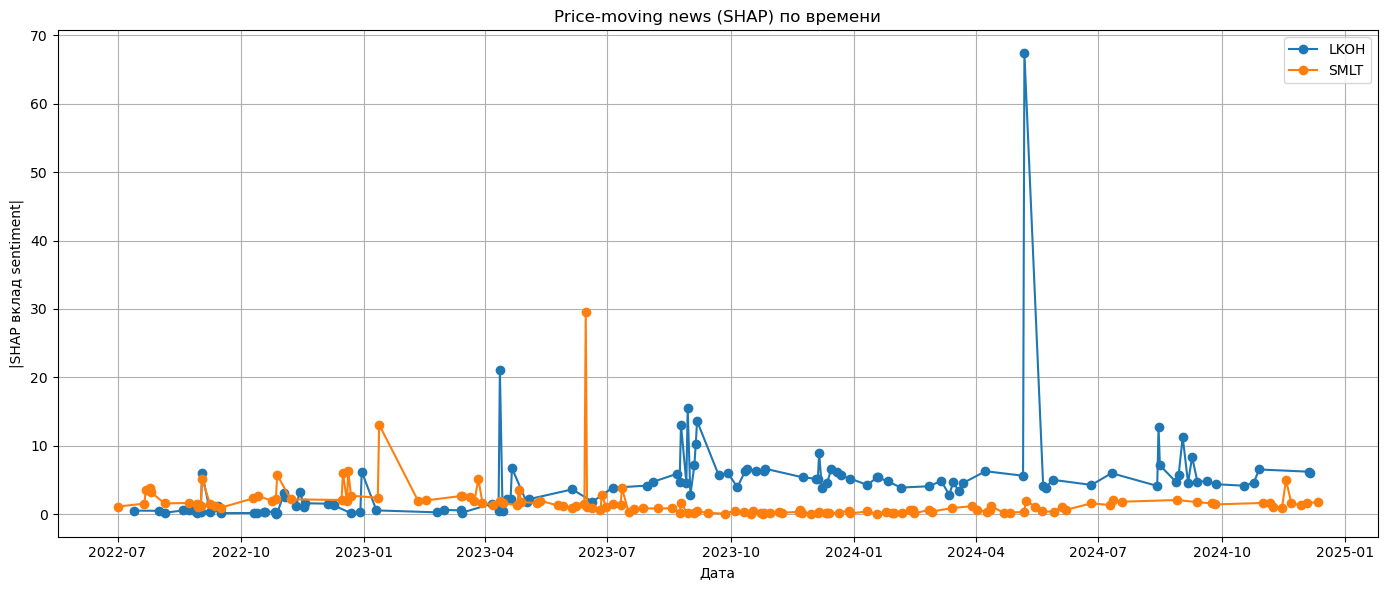

Топовые price-moving новости:
2024-05-07 00:00:00 | LKOH | SHAP=67.365
→ (2) Лукойл (LKOH): дивгэп.

2023-06-15 00:00:00 | SMLT | SHAP=29.534
→ " Источники РДВ на ПМЭФ послушали выступление СЕО Самолет (SMLT) Антона Елистратова.

2023-04-12 00:00:00 | LKOH | SHAP=21.134
→ "️️️ Подтверждено: Лукойл (LKOH) продаёт НПЗ на Сицилии. | Лукойл (LKOH) может стать самой дивидендной нефтяной акцией года.

2023-08-30 00:00:00 | LKOH | SHAP=15.495
→ Лукойл (LKOH) 4.77 5.

2023-09-06 00:00:00 | LKOH | SHAP=13.601
→ #аналитика Лукойл (LKOH). | В Топ рейтинга попадали четыре компании: Лукойл (LKOH), Самолет (SMLT), Группа Позитив (POSI) и Whoosh (WUSH).

2023-01-12 00:00:00 | SMLT | SHAP=13.079
→ "Самолет (SMLT): справедливая стоимость 4155 рублей на акцию, потенциал роста +63%. | $$$ Фундаментальная $$$ • ГК Самолет (SMLT) — одна из крупнейших федеральных корпораций в сфере девелопмента и PropTech (property technology, технологии в области недвижимости).

2023-08-25 00:00:00 | LKOH | SHAP=13.064
→ "

In [74]:
price_moving_df = plot_price_moving_shap(
    model=model,
    df_model=df_model,
    df_sent=df_sent,
    cat_features=["ticker"],
    shap_threshold=0.05,
    top_n=15
)

In [78]:
df_search = pd.read_parquet("RussianFinancialNews/news_collection.parquet")
news_by_company = map_news_to_companies(df_search, company_dict)
mask = df_search['date'].astype(str).str.contains('2023-08-30') & \
       df_search['body'].str.contains(' 4.77 5', regex=False)
       
result = df_search[mask]
if not result.empty:
    print(f"Найдено {len(result)} записей:")
    for idx, row in result.iterrows():
        print(f"Дата: {row['body']}")
else:
    print("В исходном DataFrame запись не найдена")

Найдено 1 записей:
Дата: "Топ-10 российских компаний по капитализации. По состоянию на 30 августа 2023, в трлн руб. #цифры 1. Сбер (SBER, SBERP) 6.02 2. Роснефть (ROSN) 5.75 3. Новатэк (NVTK) 5.17 4. Лукойл (LKOH) 4.77 5. Газпром (GAZP) 4.22 6. Газпромнефть (SIBN) 3.07 7. Норникель (GMKN) 2.63 8. Полюс (PLZL) 1.57 9. Сургутнефтегаз (SNGS, SNGSP) 1.51 10. Татнефть (TATN, TATNP) 1.34  "


Анализ SHAP показал, что рынок реагирует не на общий тон новостей, а на конкретные события — прежде всего дивидендные решения и корпоративные действия. В обычные дни вклад сентимента невелик, но в событийные периоды он становится значимым драйвером движения цены. Это подтверждает гипотезу о нерегулярном и событийном характере влияния новостей. Рынок особенно чувствителен к дивидендным и корпоративным событиям, а не к общему информационному фону.

Выводы:
1. Новостной сентимент статистически значим.
2. Эффект носит событийный характер.
3. Реакция асимметрична и зависит от типа новости.
4. SHAP позволяет перейти от «предсказания» к «объяснению движения цены».